In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
N_DONORS=4 


In [3]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns


from vireoSNP import Vireo

import pickle

np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

fig_utils from mplh
here
0.4.2


In [4]:
### Run lineage tracing for each cluster individually
def run_elbo(ad, dp, out_f="", n_clone_list=None, save_clusters=True, labels=None, rerun_model=False):
    
    if n_clone_list is None:
        n_clone_list = np.arange(2,5)
    n_initials = 50
    _ELBO_mat = [] 
    
    for k in n_clone_list:
        print('lineages', k)
        curr_clone_model_f = out_f+f"clones{k}.modelCA.p"
        curr_lineage_f =  out_f + f"clones{k}.lineages.png"
        if os.path.exists(curr_clone_model_f) and (not rerun_model):
            print('Already ran. Loading model')
            modelCA = pickle.load(open(curr_clone_model_f, "rb"))
        else:
            _models_all = []
            _elbo_temp = []
            for i in range(50):
                _modelCA = Vireo(n_var=ad.todense().shape[0], n_cell=ad.todense().shape[1], n_donor=k, n_GT=2,
                                 fix_beta_sum=False, ASE_mode=True)
                _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
                _modelCA.fit(ad, dp, min_iter=20, verbose=False)
                _elbo_temp.append(_modelCA.ELBO_[-1])
                _models_all.append(_modelCA)

            _ELBO_mat.append(_elbo_temp)
            _idx = np.argmax([x.ELBO_[-1] for x in _models_all])
            modelCA = _models_all[_idx]
            _losses = modelCA.ELBO_
            pickle.dump(modelCA, open(out_f+f"clones{k}.modelCA.p", "wb"))

            # Run the plot_vireo_out
        ## Choose the model giving highest ELBO
        if save_clusters and not (out_f == ""):
            print('saving lineage tree for file:', curr_lineage_f)
            doublet_prob = modelCA.predict_doublet(ad, dp, update_GT=False, update_ID=False)[0].sum(axis=1)
            plot_vireo_out(modelCA, out_f=curr_lineage_f, to_sqrt=True, labels=labels, 
                          doublet_prob=doublet_prob)
    if len(_ELBO_mat) !=0:
        f = plt.figure()
        plt.boxplot(_ELBO_mat)
        plt.plot(np.arange(1,len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
        #plt.xticks(n_clone_list)
        plt.gca().set_xticklabels(n_clone_list)
        plt.ylabel("ELBO")
        plt.xlabel("n_clones")
        if out_f != "":
            plt.savefig(out_f)
        plt.show()
    return _ELBO_mat, n_clone_list


def plot_vireo_out(modelCA, out_f, to_sqrt=False, labels=None, doublet_prob=None):
    if labels is not None:
        clust_df = pd.DataFrame(modelCA.ID_prob+np.random.uniform(low=0.0, high=0.0000005, size=modelCA.ID_prob.shape),
                       columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])], index=labels.index)
        if doublet_prob is not None:
            clust_df = pd.concat((clust_df,pd.DataFrame(doublet_prob, columns=["Doublet"])), axis=1)
        ch.plot_cluster(clust_df, cmap='Oranges', alpha=0.8, 
                        to_row_clust=True, to_col_clust=False,
                        row_meta=labels, to_legend=True, white_name=None)
        plt.suptitle("Cell-cluster probability")
        plt.savefig(out_f+".labels.png")
        #plt.close()

    fig = plt.figure(figsize=(7, 4), dpi=100)
    plt.subplot(1, 2, 1)
    im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(modelCA.n_cell))
    plt.xticks(range(modelCA.n_donor))
    plt.subplot(1, 2, 2)
    AF_SNPs = np.sum(modelCA.GT_prob * 
                     np.expand_dims(modelCA.beta_mu, 1), axis=2)
    if to_sqrt:
        AF_SNPs = np.sqrt(AF_SNPs)

    #f = plt.figure()    
    im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" %(modelCA.n_var))
    plt.xticks(range(modelCA.n_donor))
    plt.tight_layout()
    plt.savefig(out_f)
    plt.close()
    
    ch.plot_cluster(pd.DataFrame(AF_SNPs), cmap='Blues', alpha=0.8, 
                to_row_clust=True, to_col_clust=True, to_legend=True, white_name=None)
    plt.savefig(out_f+".variants.labels.png")
    #plt.show()
    return

In [5]:
n=0
k=5
out_f = join(OUTDIR, f"cluster{n}_lineage_elbow.png")
curr_clone_model_f = out_f+f"clones{k}.modelCA.p"
if os.path.exists(curr_clone_model_f):
    print('Already ran. Loading model')
    modelCA = pickle.load(open(curr_clone_model_f, "rb"))

Already ran. Loading model


## Run each lineage separately

  0%|          | 0/4 [00:00<?, ?it/s]

n 0
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0.DP.txt
lineages 5
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones5.lineages.png
cmap Oranges
cmap Blues
lineages 10
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones10.lineages.png
cmap Oranges
cmap Blues
lineages 20
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones20.lineages.png
cmap Oranges
cmap Blues
lineages 40
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0_lineage_elbow.pngclones40.l

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/seaborn/matrix.py:771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure(figsize=figsize)
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


cmap Blues
lineages 10
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones10.lineages.png
cmap Oranges
cmap Blues
lineages 20
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones20.lineages.png
cmap Oranges
cmap Blues
lineages 40
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones40.lineages.png
cmap Oranges
cmap Blues
lineages 100
Already ran. Loading model
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2_lineage_elbow.pngclones100.lineages.png
cmap Oranges
cmap Blues
n 3
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster3.AD.txt
data/jan21_2021/chrM/pseudo/minC200_mi

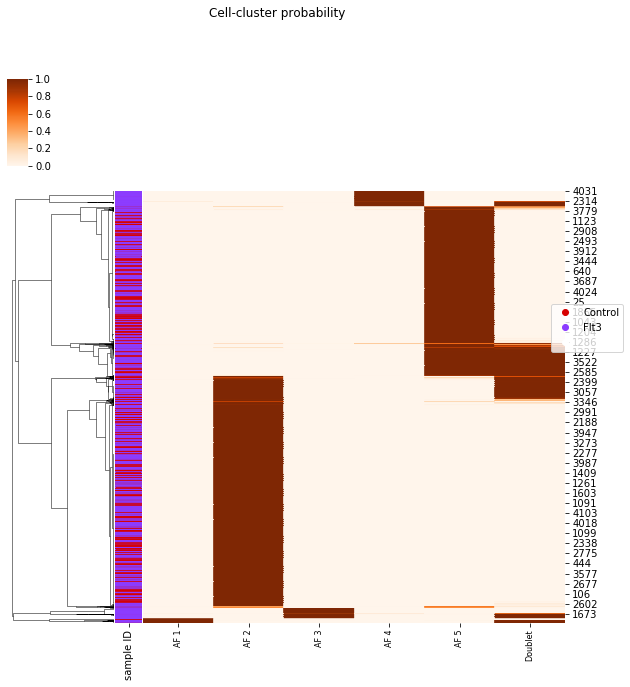

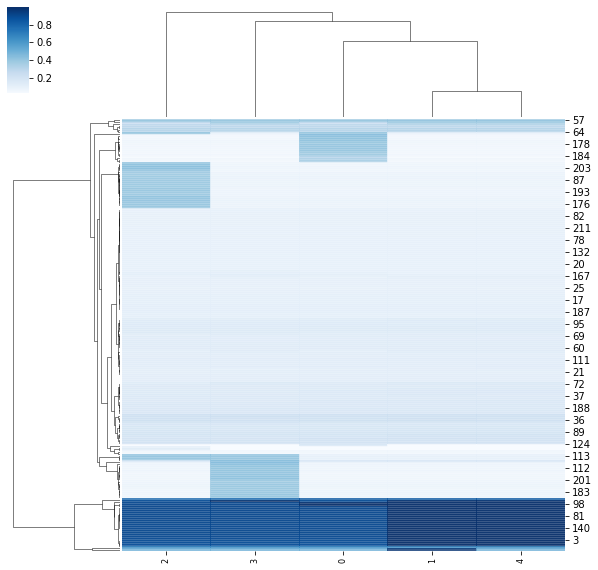

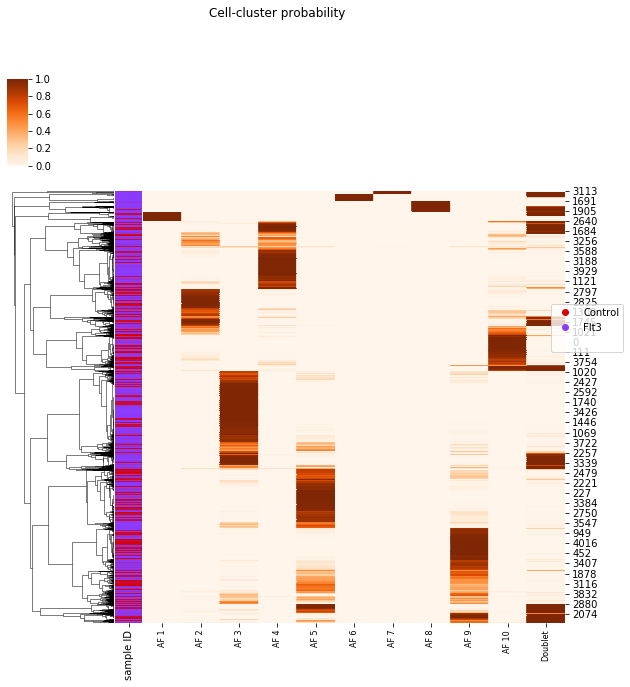

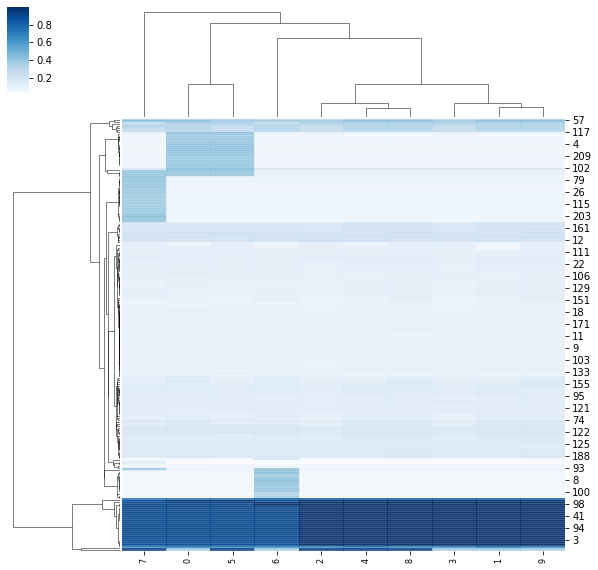

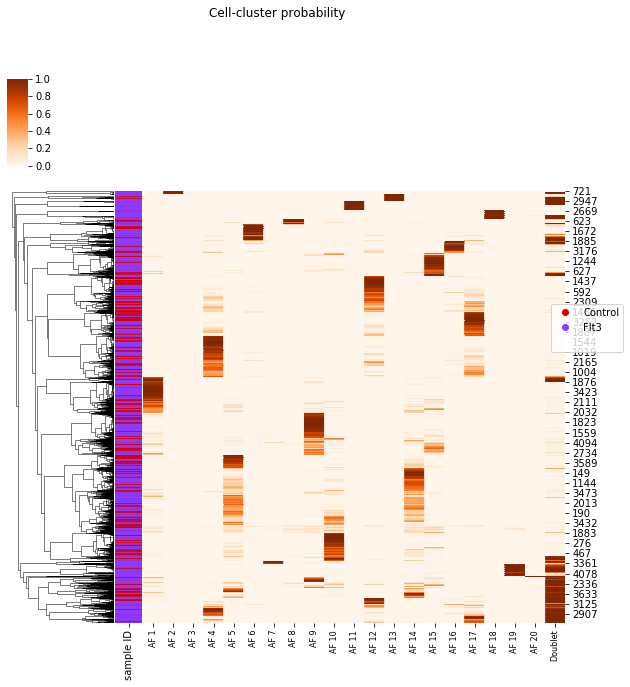

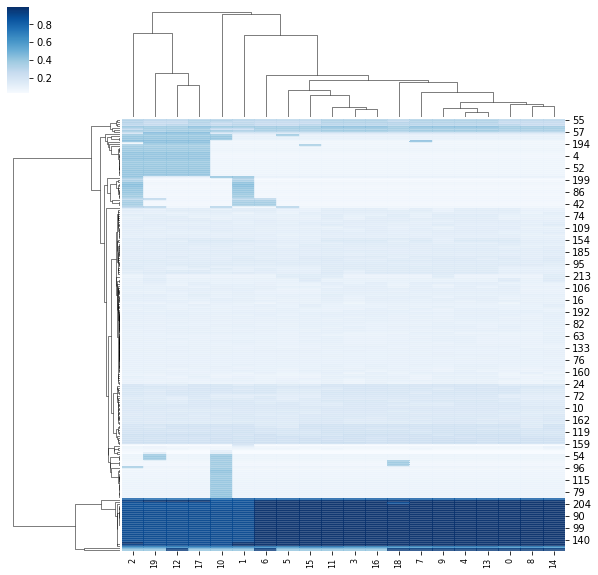

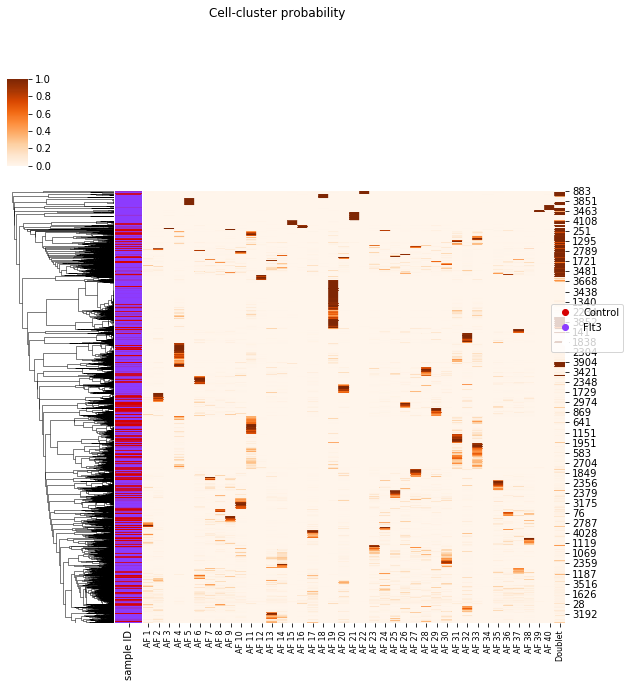

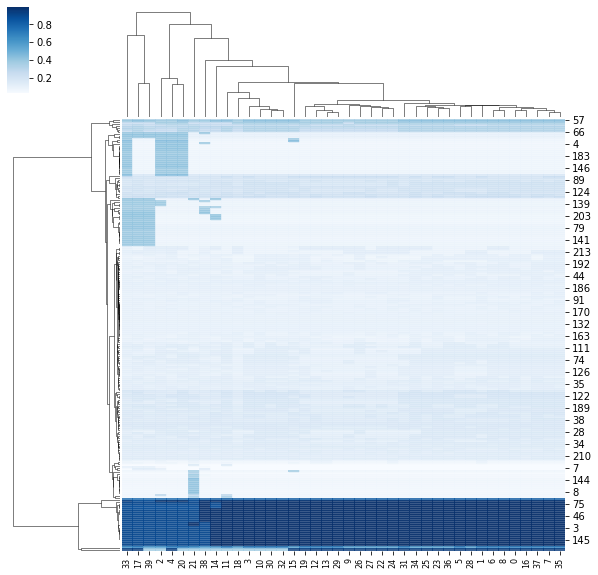

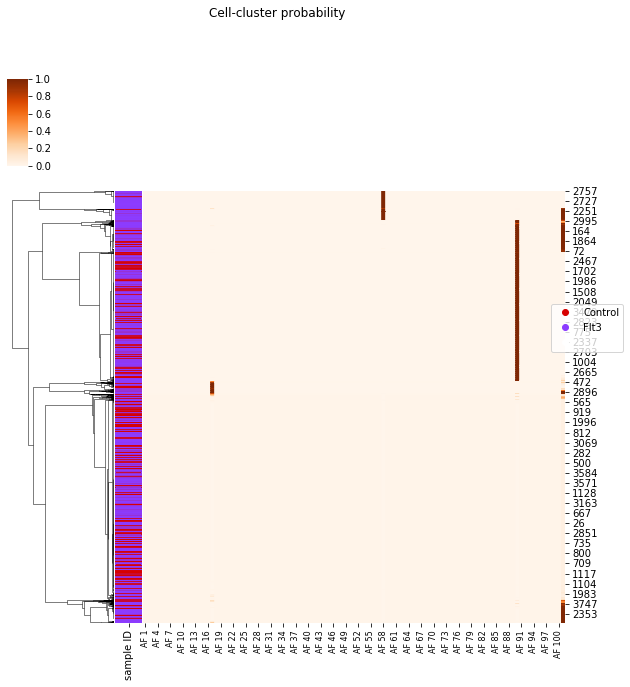

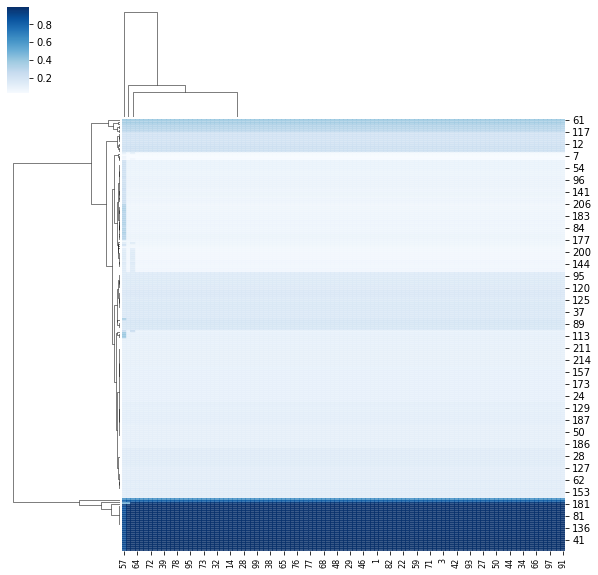

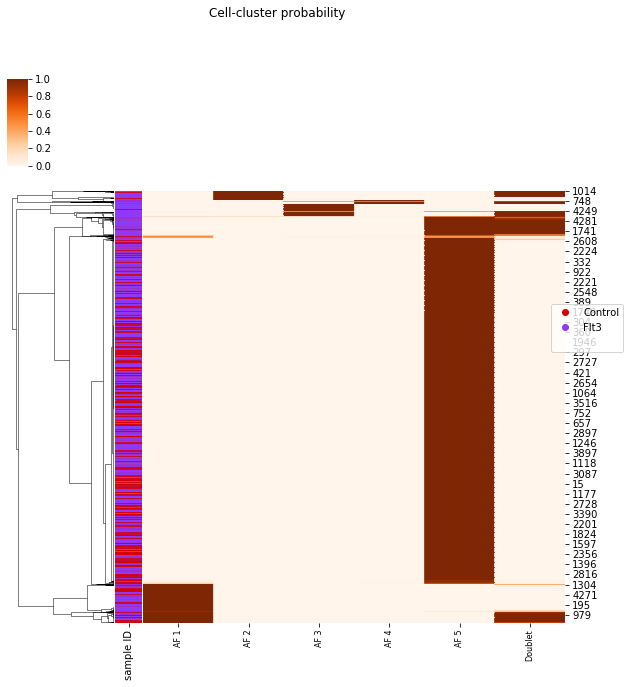

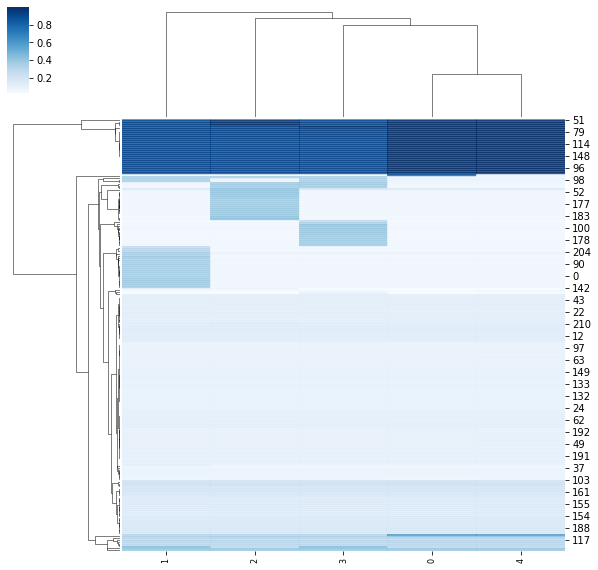

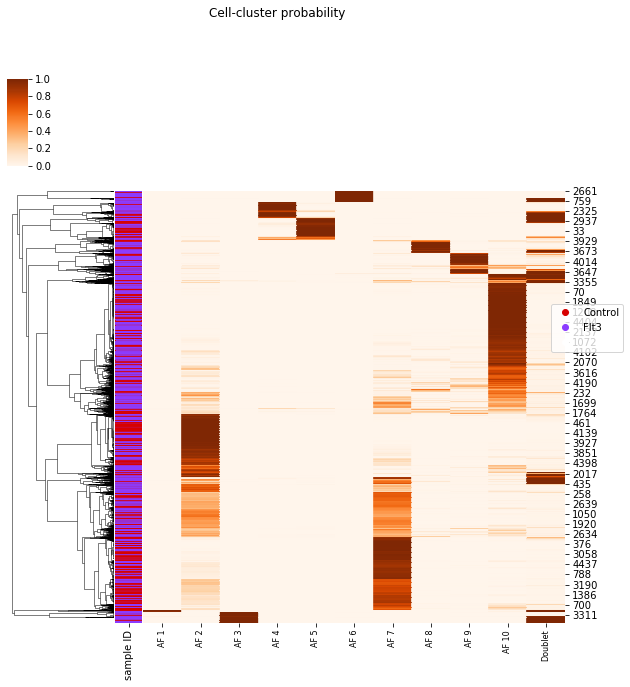

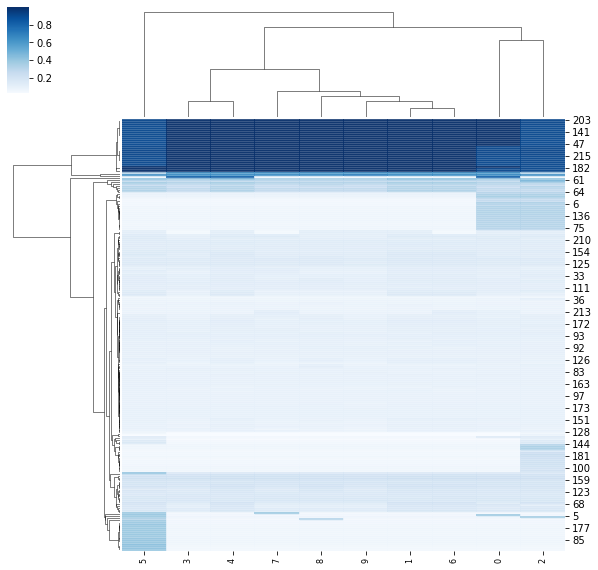

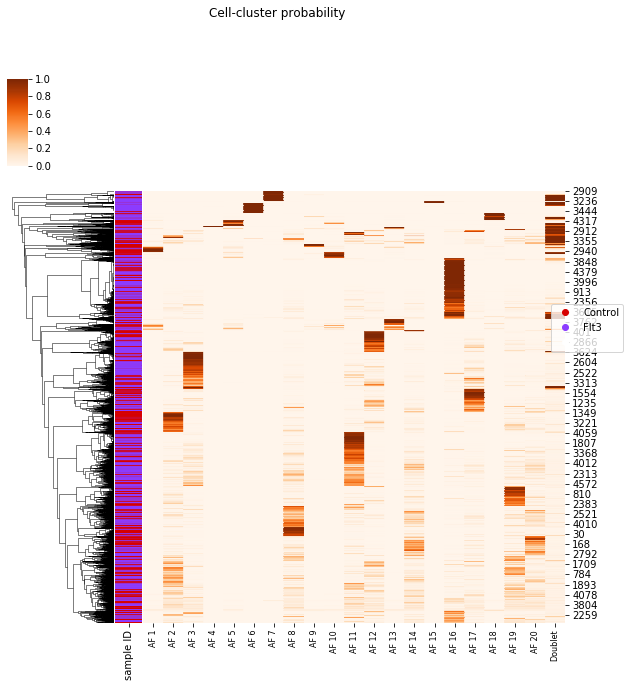

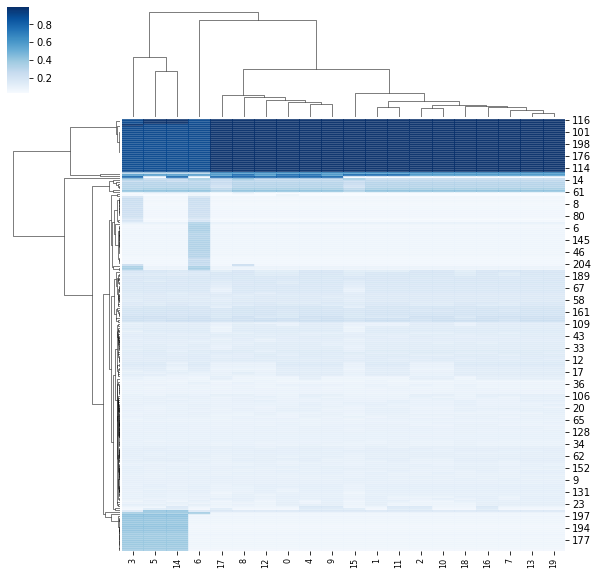

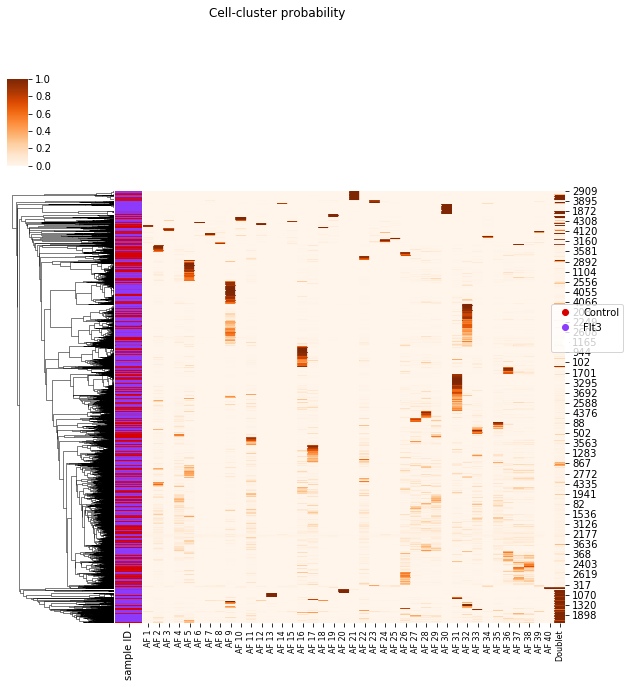

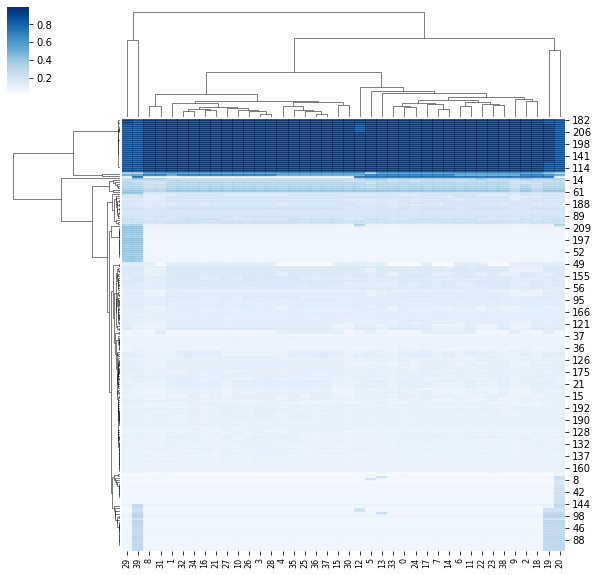

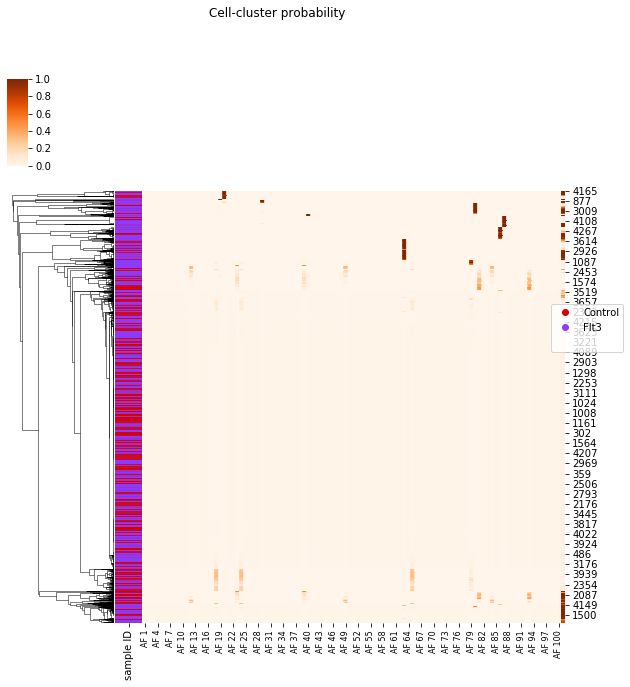

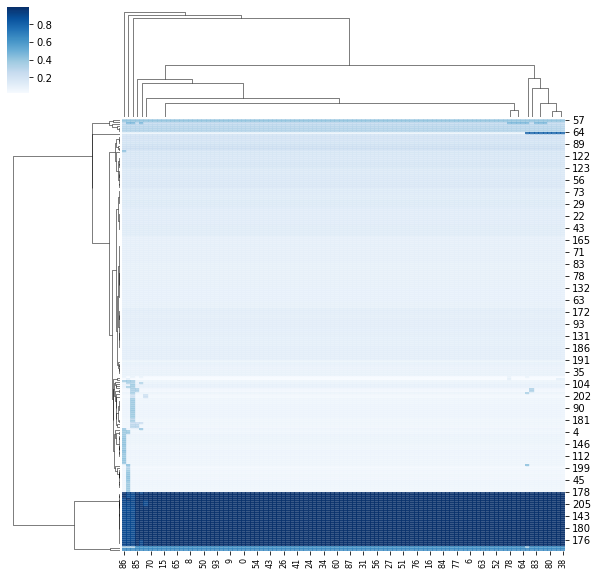

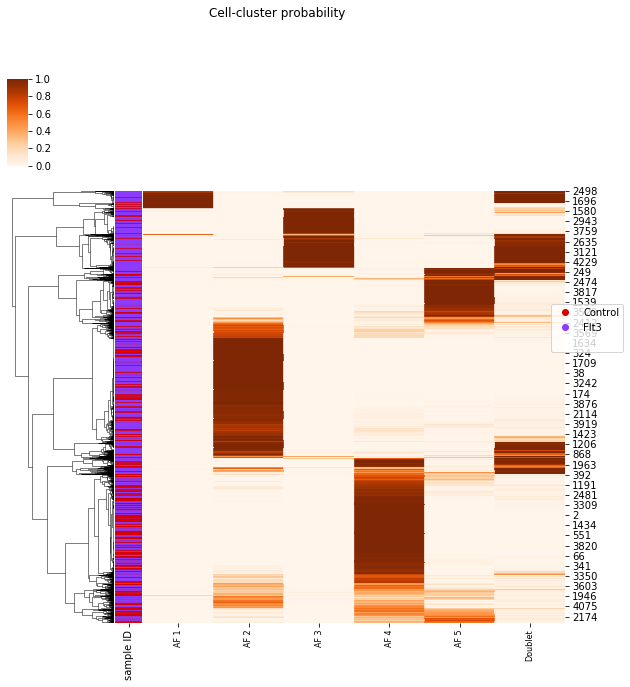

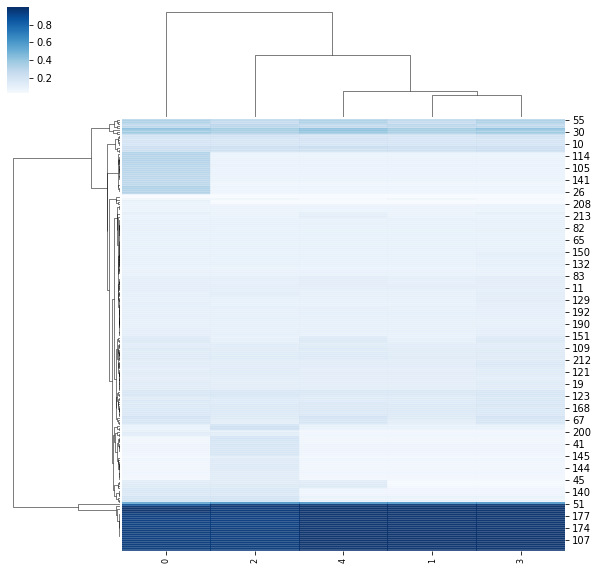

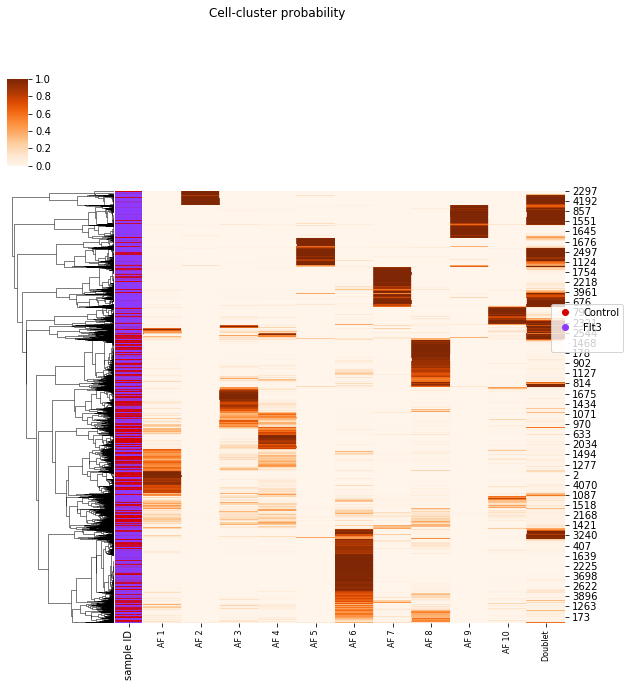

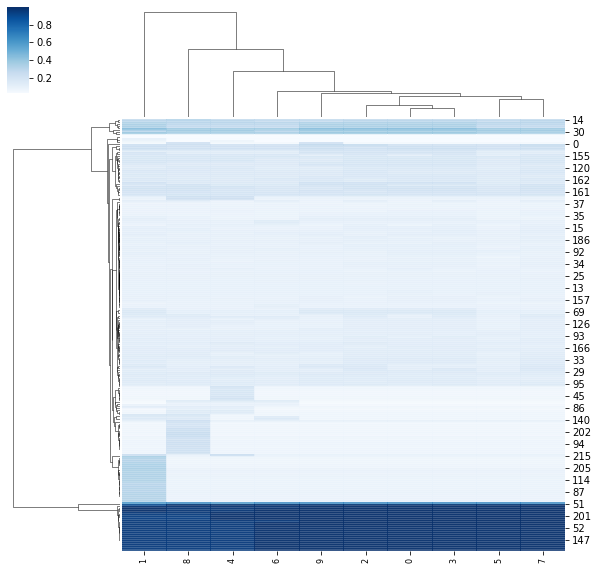

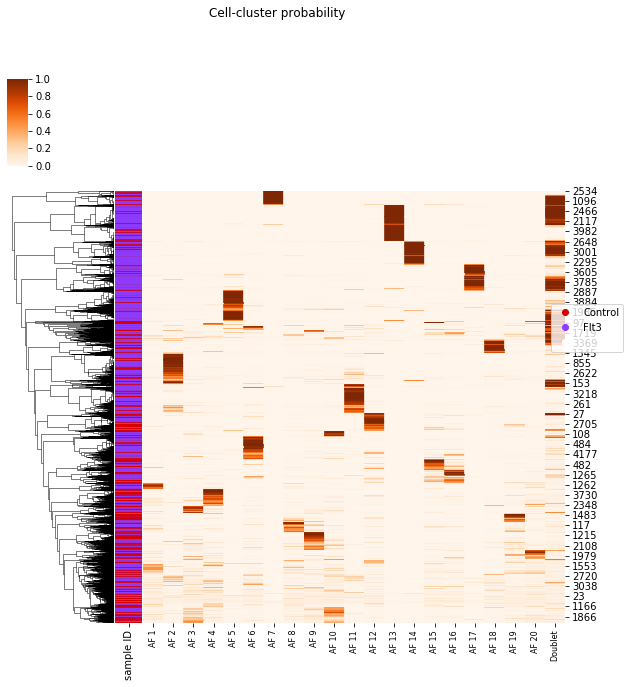

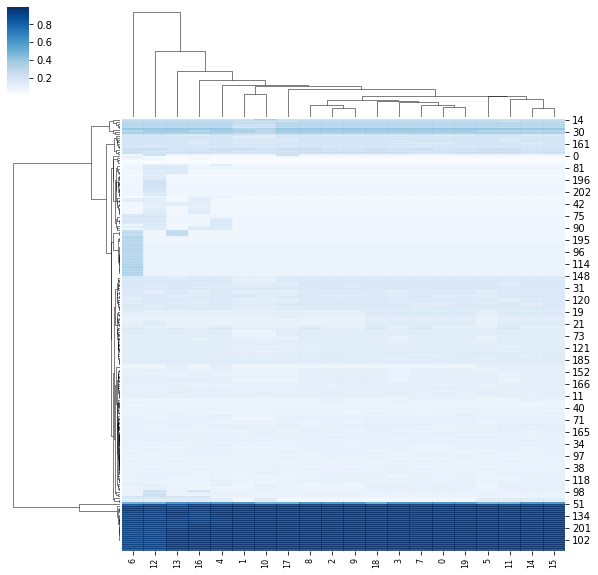

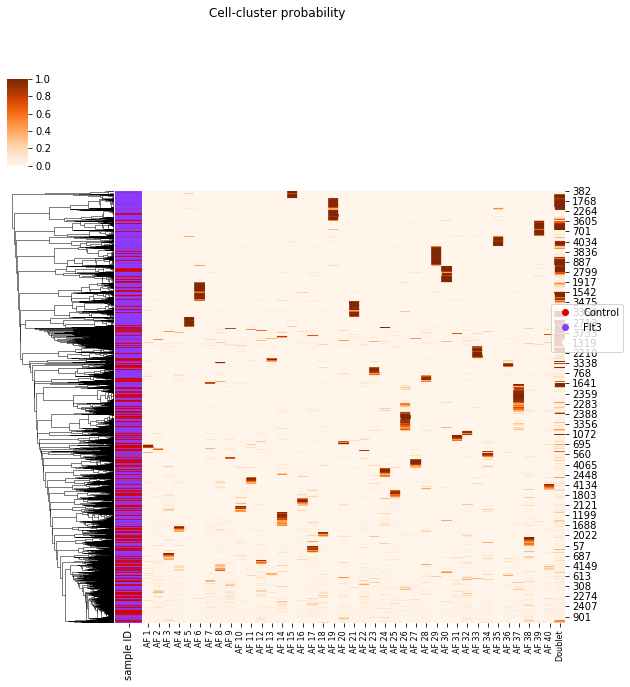

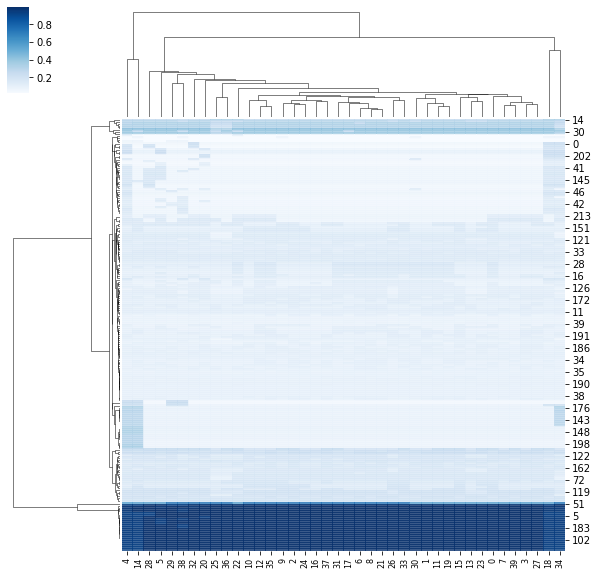

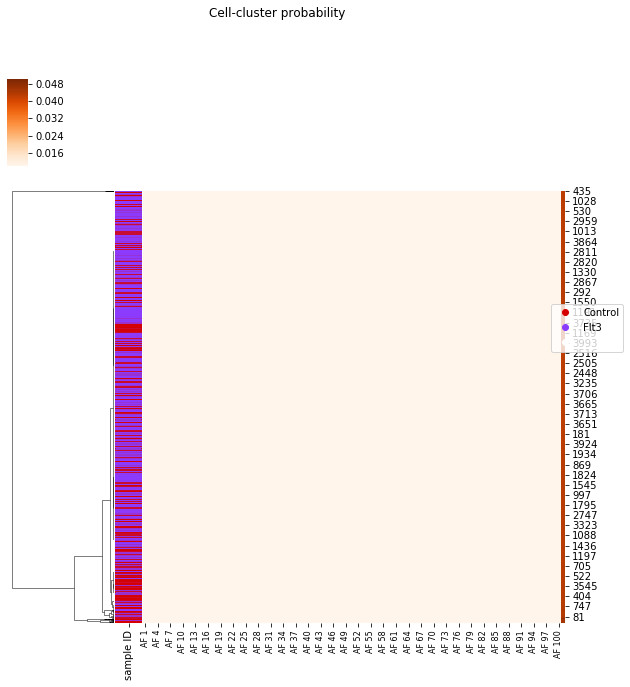

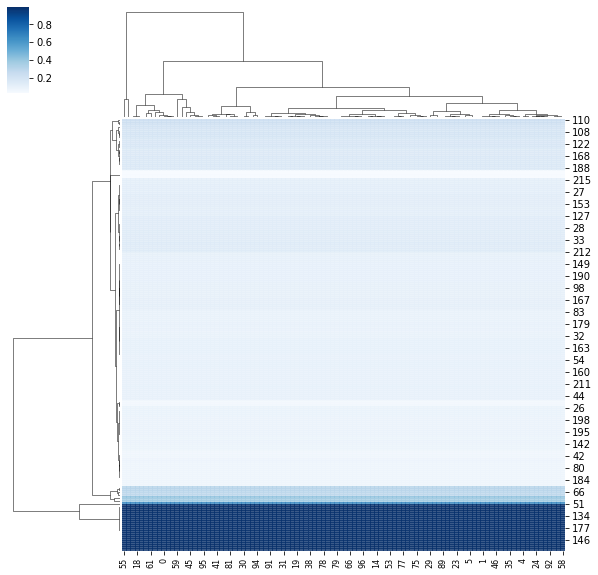

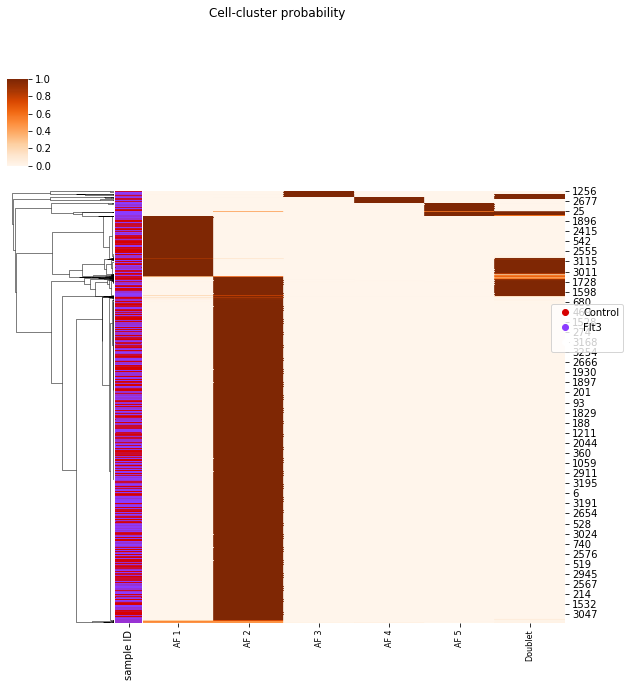

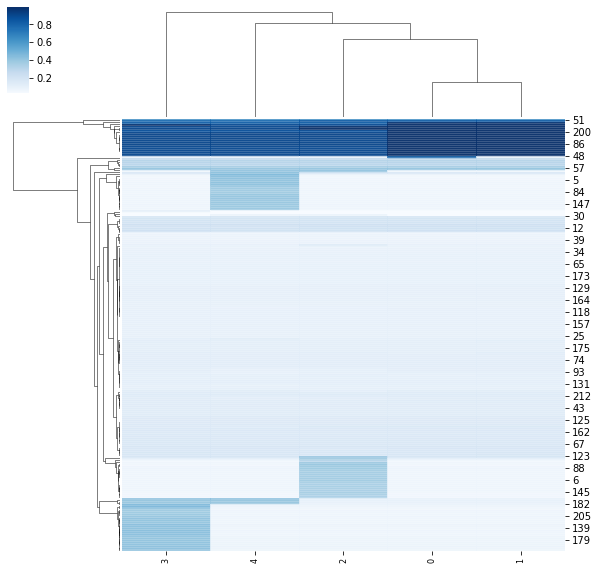

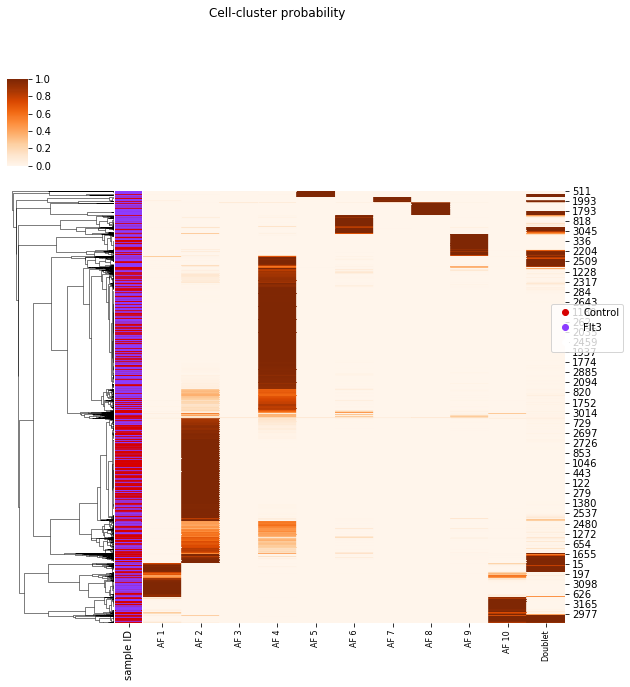

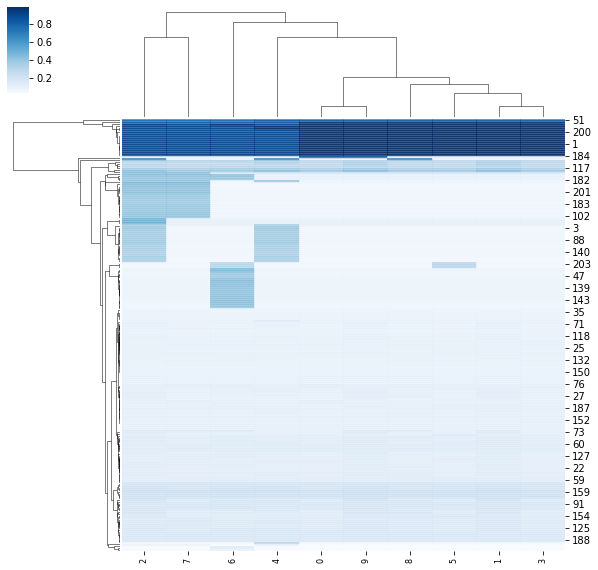

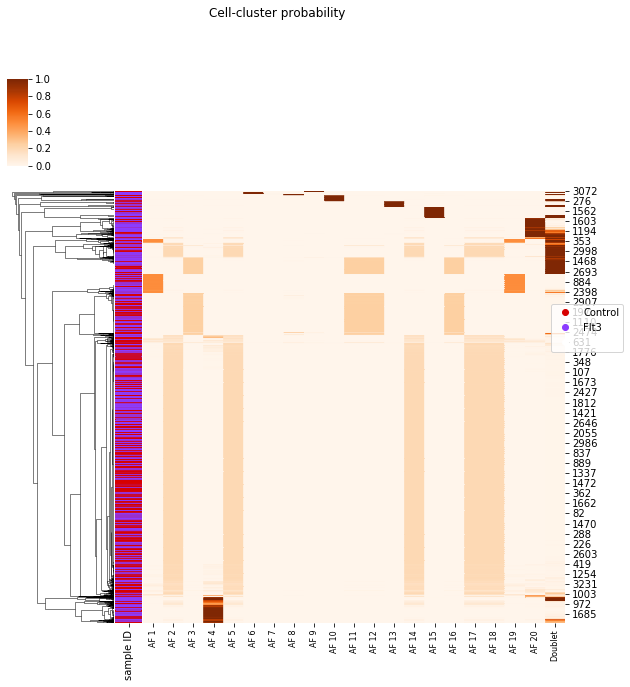

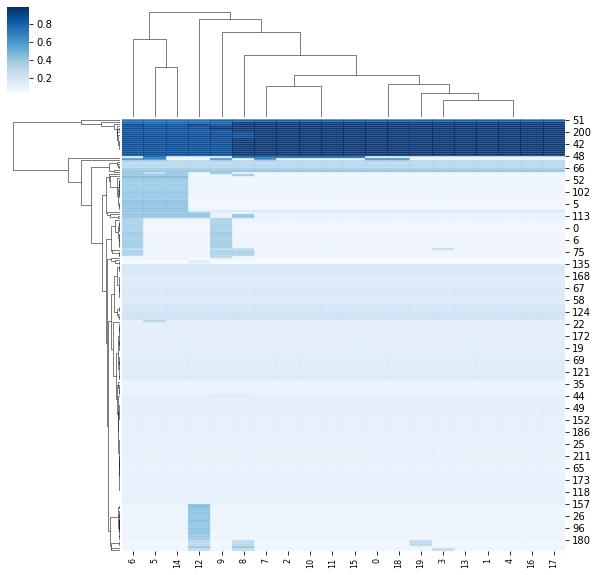

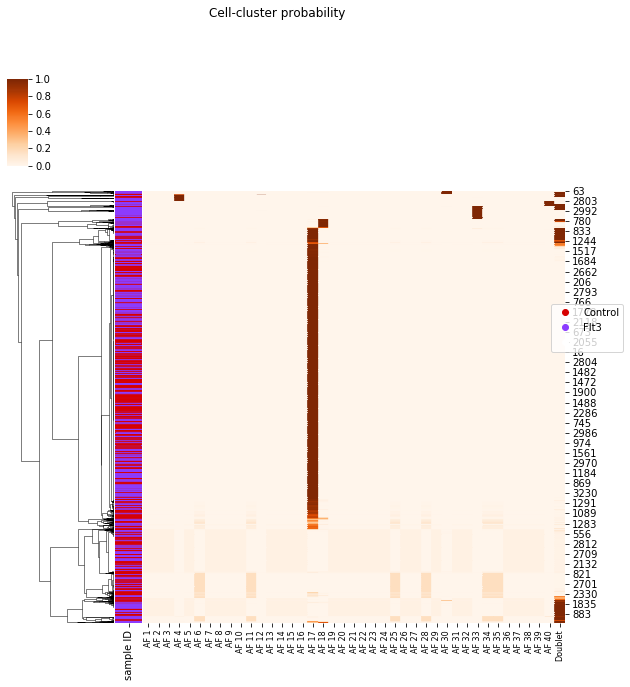

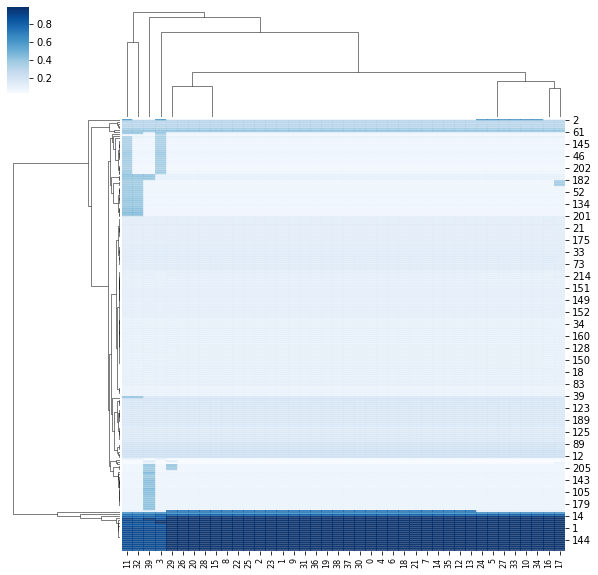

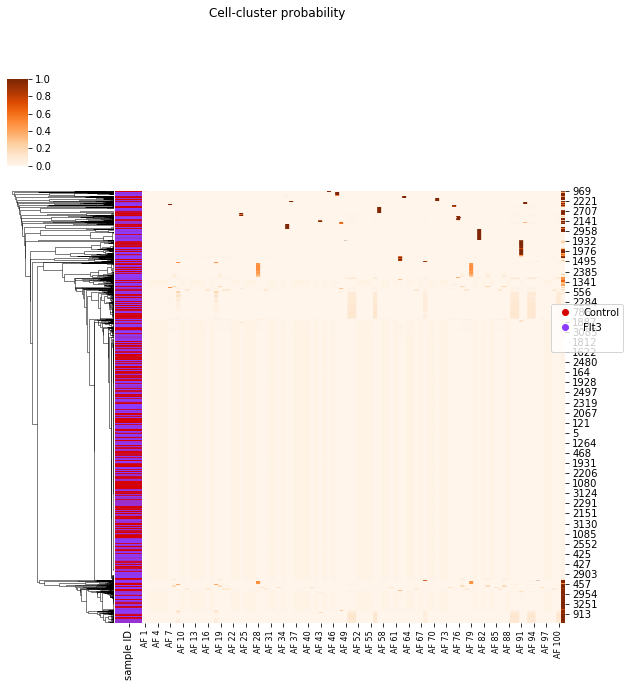

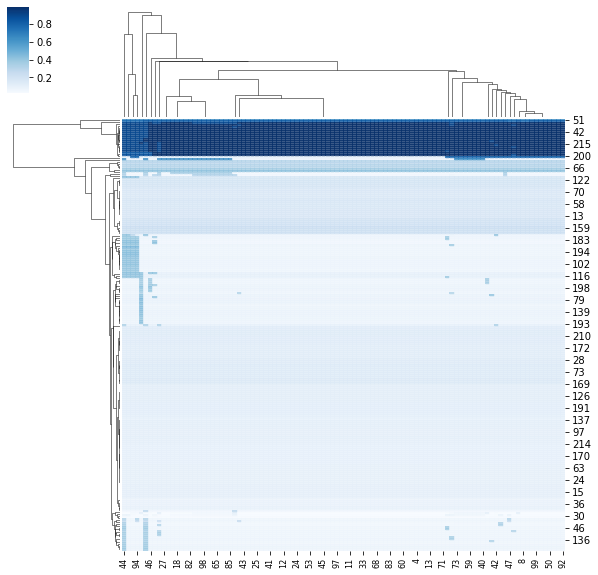

In [6]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm


num_cores = N_DONORS #multiprocessing.cpu_count()
inputs = tqdm(np.arange(N_DONORS))

def run_lineage(n, OUTDIR, n_clone_list=[5, 10, 20, 40, 100], rerun_model=False):
    curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
    curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
    print(curr_ad_f)
    print(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    curr_labels = pd.read_csv(join(OUTDIR, f"cluster{n}.labels.txt"), index_col=0)
    run_elbo(curr_ad, curr_dp, join(OUTDIR, f"cluster{n}_lineage_elbow.png"), n_clone_list=n_clone_list,
             save_clusters=True, labels=curr_labels[["sample ID"]], rerun_model=rerun_model)
    return

for n in np.arange(N_DONORS):
    print('n', n)
    run_lineage(n, OUTDIR, n_clone_list=[5, 10, 20, 40, 100], rerun_model=False)
#processed_list = Parallel(n_jobs=num_cores)(delayed(run_lineage)(i,OUTDIR) for i in inputs)